In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


from scipy import stats
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.metrics import f1_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,plot_tree
from sklearn import metrics

from xgboost import XGBClassifier, plot_tree
import xgboost as xgb

from statsmodels.formula.api import ols
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import pickle


### Importation CSV et création du dataframe

In [4]:
df = pd.read_csv("data.csv")
df.NewExist = df.NewExist.astype(str)
df.UrbanRural= df.UrbanRural.astype(str)
df.Real_estate = df.Real_estate.astype(str)
df

,State,BankState,Industry,Term,GrAppv,MIS_Status,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,Real_estate
0,IN,OH,Retail trade,84,60000.0,0,4,1,0,0,1,0,0
1,IN,IN,Accommodation and food services,60,40000.0,0,2,1,0,0,1,0,0
2,IN,IN,Health care and social assistance,180,287000.0,0,7,0,0,0,1,0,0
3,OK,OK,Others,60,35000.0,0,2,0,0,0,1,0,0
4,FL,FL,Others,240,229000.0,0,14,0,7,7,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
893285,OH,IL,Retail trade,60,70000.0,0,6,0,0,0,1,0,0
893286,OH,IL,Retail trade,60,85000.0,0,6,0,0,0,1,0,0
893287,CA,CA,Manufacturing,108,300000.0,0,26,0,0,0,1,0,0
893288,HI,HI,Others,60,75000.0,1,6,0,0,0,1,0,0


In [5]:
df.columns

Index(['State', 'BankState', 'Industry', 'Term', 'GrAppv', 'MIS_Status',
       'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode',
       'UrbanRural', 'Real_estate'],
      dtype='object')

In [5]:
df.FranchiseCode = df.FranchiseCode.apply(lambda x: 1 if x ==1 else 0)
df.FranchiseCode = df.FranchiseCode.astype(str)
df.FranchiseCode.value_counts()


1    841756
0     51534
Name: FranchiseCode, dtype: int64

### Création de la matrice X (variables explicatives) et de la série y (variable cible)

In [23]:
X = df.drop(['MIS_Status'], axis=1)
y = df['MIS_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.9, random_state=42, stratify=y)

# Score du dummy classifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)



0.8248991586310156

### Création d'un pipeline

In [9]:
transformer = make_column_transformer(
    (OneHotEncoder(),make_column_selector(dtype_exclude=np.number)),
    (StandardScaler(),make_column_selector(dtype_include=np.number))
    )

### Création d'un  RandomForest

In [25]:
forest= make_pipeline(
    transformer,
    RandomForestClassifier(
        max_depth=5,
        n_estimators=100,
        min_samples_leaf=1000,
        class_weight='balanced'
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
forest.fit(X_train,y_train)

#Utilisation d'un .features_importances_ pour déterminer quelle variable est importante pour la prédiction
A=forest.named_steps['randomforestclassifier'].feature_importances_

# #Score de notre modèle après la cross_validation
cross_val=cross_validate(forest, X_train, y_train,scoring='f1',cv=5)

cross_val['test_score'].mean()

0.5738146105334867

In [26]:
# y_pred=forest.predict(X_train)
# f1_score(y_train,y_pred)

In [27]:
A_columns=transformer.get_feature_names_out()
A_columns

array(['onehotencoder__State_AK', 'onehotencoder__State_AL',
       'onehotencoder__State_AR', 'onehotencoder__State_AZ',
       'onehotencoder__State_CA', 'onehotencoder__State_CO',
       'onehotencoder__State_CT', 'onehotencoder__State_DC',
       'onehotencoder__State_DE', 'onehotencoder__State_FL',
       'onehotencoder__State_GA', 'onehotencoder__State_HI',
       'onehotencoder__State_IA', 'onehotencoder__State_ID',
       'onehotencoder__State_IL', 'onehotencoder__State_IN',
       'onehotencoder__State_KS', 'onehotencoder__State_KY',
       'onehotencoder__State_LA', 'onehotencoder__State_MA',
       'onehotencoder__State_MD', 'onehotencoder__State_ME',
       'onehotencoder__State_MI', 'onehotencoder__State_MN',
       'onehotencoder__State_MO', 'onehotencoder__State_MS',
       'onehotencoder__State_MT', 'onehotencoder__State_NC',
       'onehotencoder__State_ND', 'onehotencoder__State_NE',
       'onehotencoder__State_NH', 'onehotencoder__State_NJ',
       'onehotencoder__S

In [28]:
df_coeff = pd.DataFrame([A_columns,A], index=['features', 'coeff']).T.explode('coeff')
df_coeff.sort_values(by='coeff', ascending=False).head(20)

,features,coeff
131,standardscaler__Term,0.384352
78,onehotencoder__Real_estate_1,0.109086
76,onehotencoder__UrbanRural_1,0.105152
83,standardscaler__RetainedJob,0.095945
77,onehotencoder__Real_estate_0,0.080513
80,standardscaler__GrAppv,0.065313
75,onehotencoder__UrbanRural_0,0.046979
64,onehotencoder__Industry_Others,0.040376
82,standardscaler__CreateJob,0.019554
81,standardscaler__NoEmp,0.018172


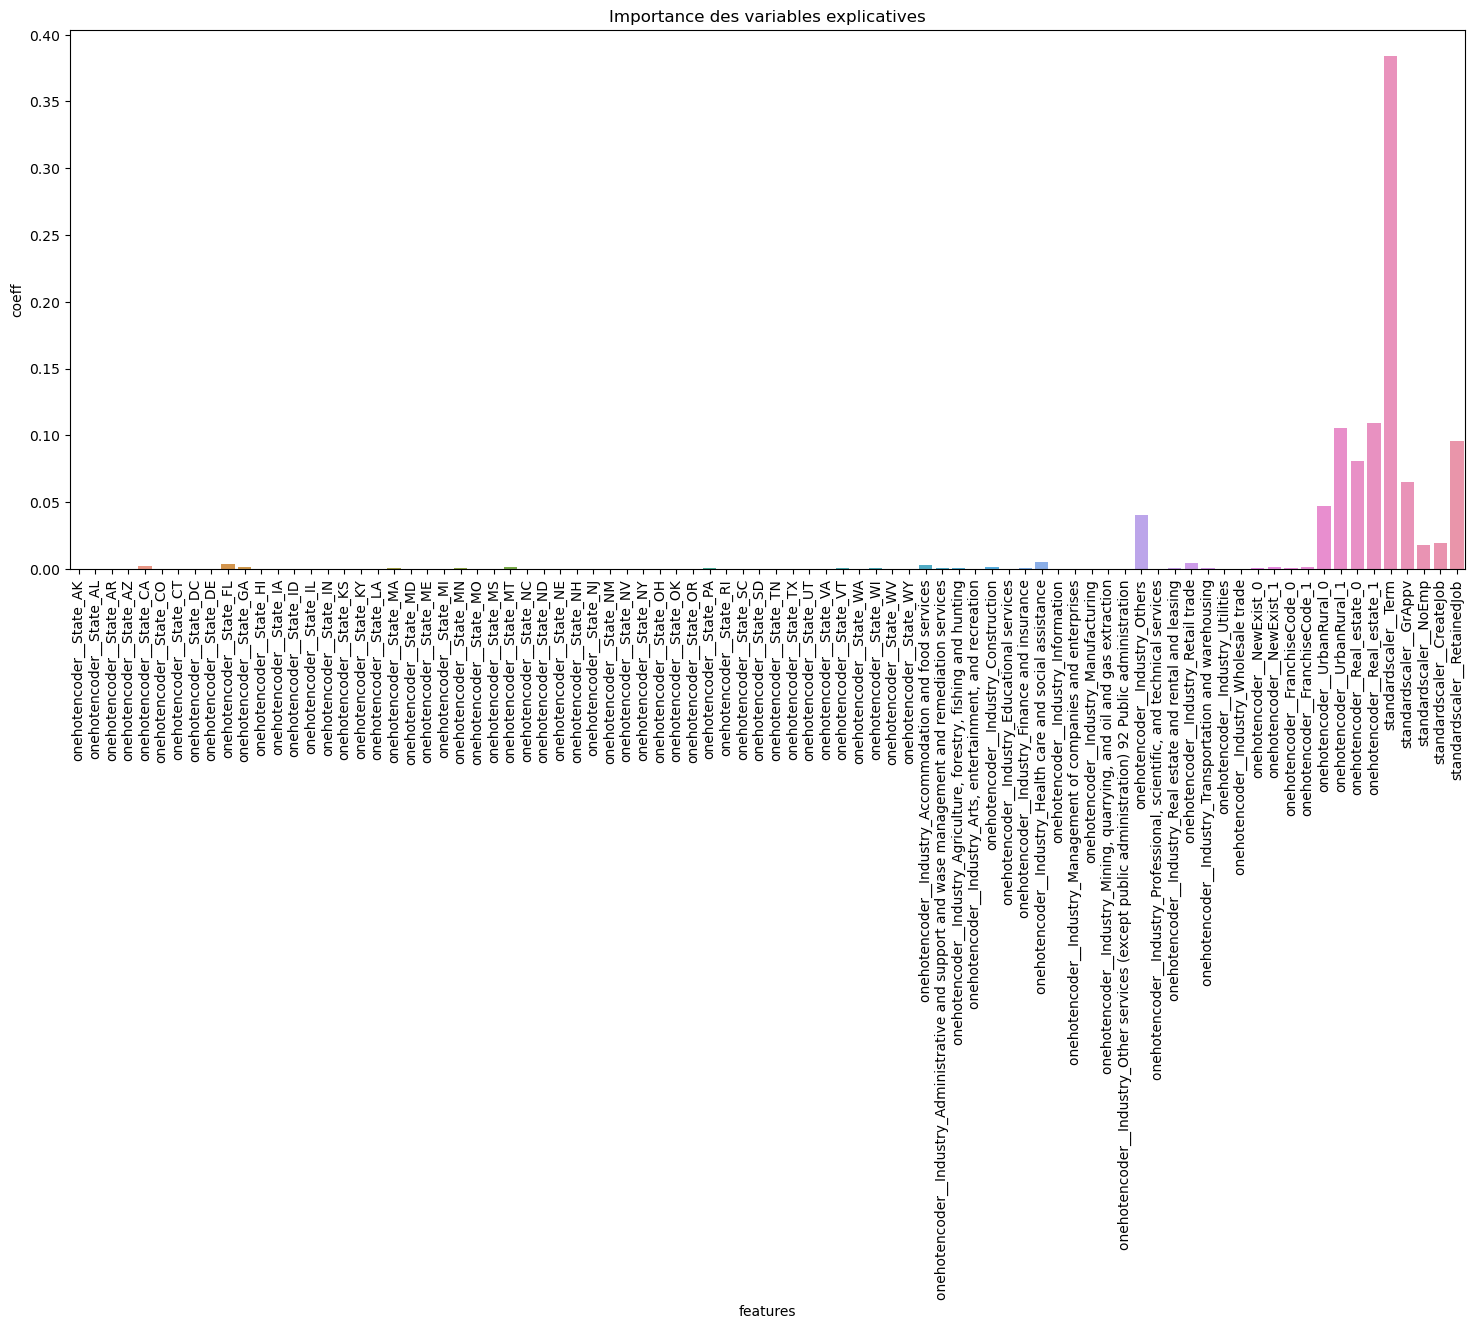

In [29]:
# plt.figure(figsize=[18,7])
# sns.barplot(data=df_coeff,x='features',y='coeff')
# plt.xticks(rotation=90)
# plt.title("Importance des variables explicatives")
# plt.show()

In [6]:
X = df[['UrbanRural','CreateJob','NoEmp','Real_estate','GrAppv','Industry','Term','State','BankState']]
y = df['MIS_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.9, random_state=42, stratify=y)

In [31]:
forest= make_pipeline(
    transformer,
    RandomForestClassifier(
        max_depth=10,
        n_estimators=100,
        min_samples_leaf=6000,
        min_samples_split=20000,
        max_leaf_nodes=15,
        class_weight='balanced'
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
forest.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6ff815b8b0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6ff815bb20>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_leaf_nodes=15,
                                        min_samples_leaf=6000,
                                        min_samples_split=20000))])

In [7]:
# y_pred=cross_val_predict(forest,X_train, y_train)

NameError: name 'forest' is not defined

In [ ]:
y_pred=cross_val_predict(forest,X_train, y_train)

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86    664423
           1       0.44      0.82      0.58    141041

    accuracy                           0.79    805464
   macro avg       0.70      0.80      0.72    805464
weighted avg       0.86      0.79      0.81    805464



In [ ]:
cross_val=cross_validate(forest, X_train, y_train,scoring='f1_macro',cv=5)

cross_val['test_score'].mean()

KeyboardInterrupt: 

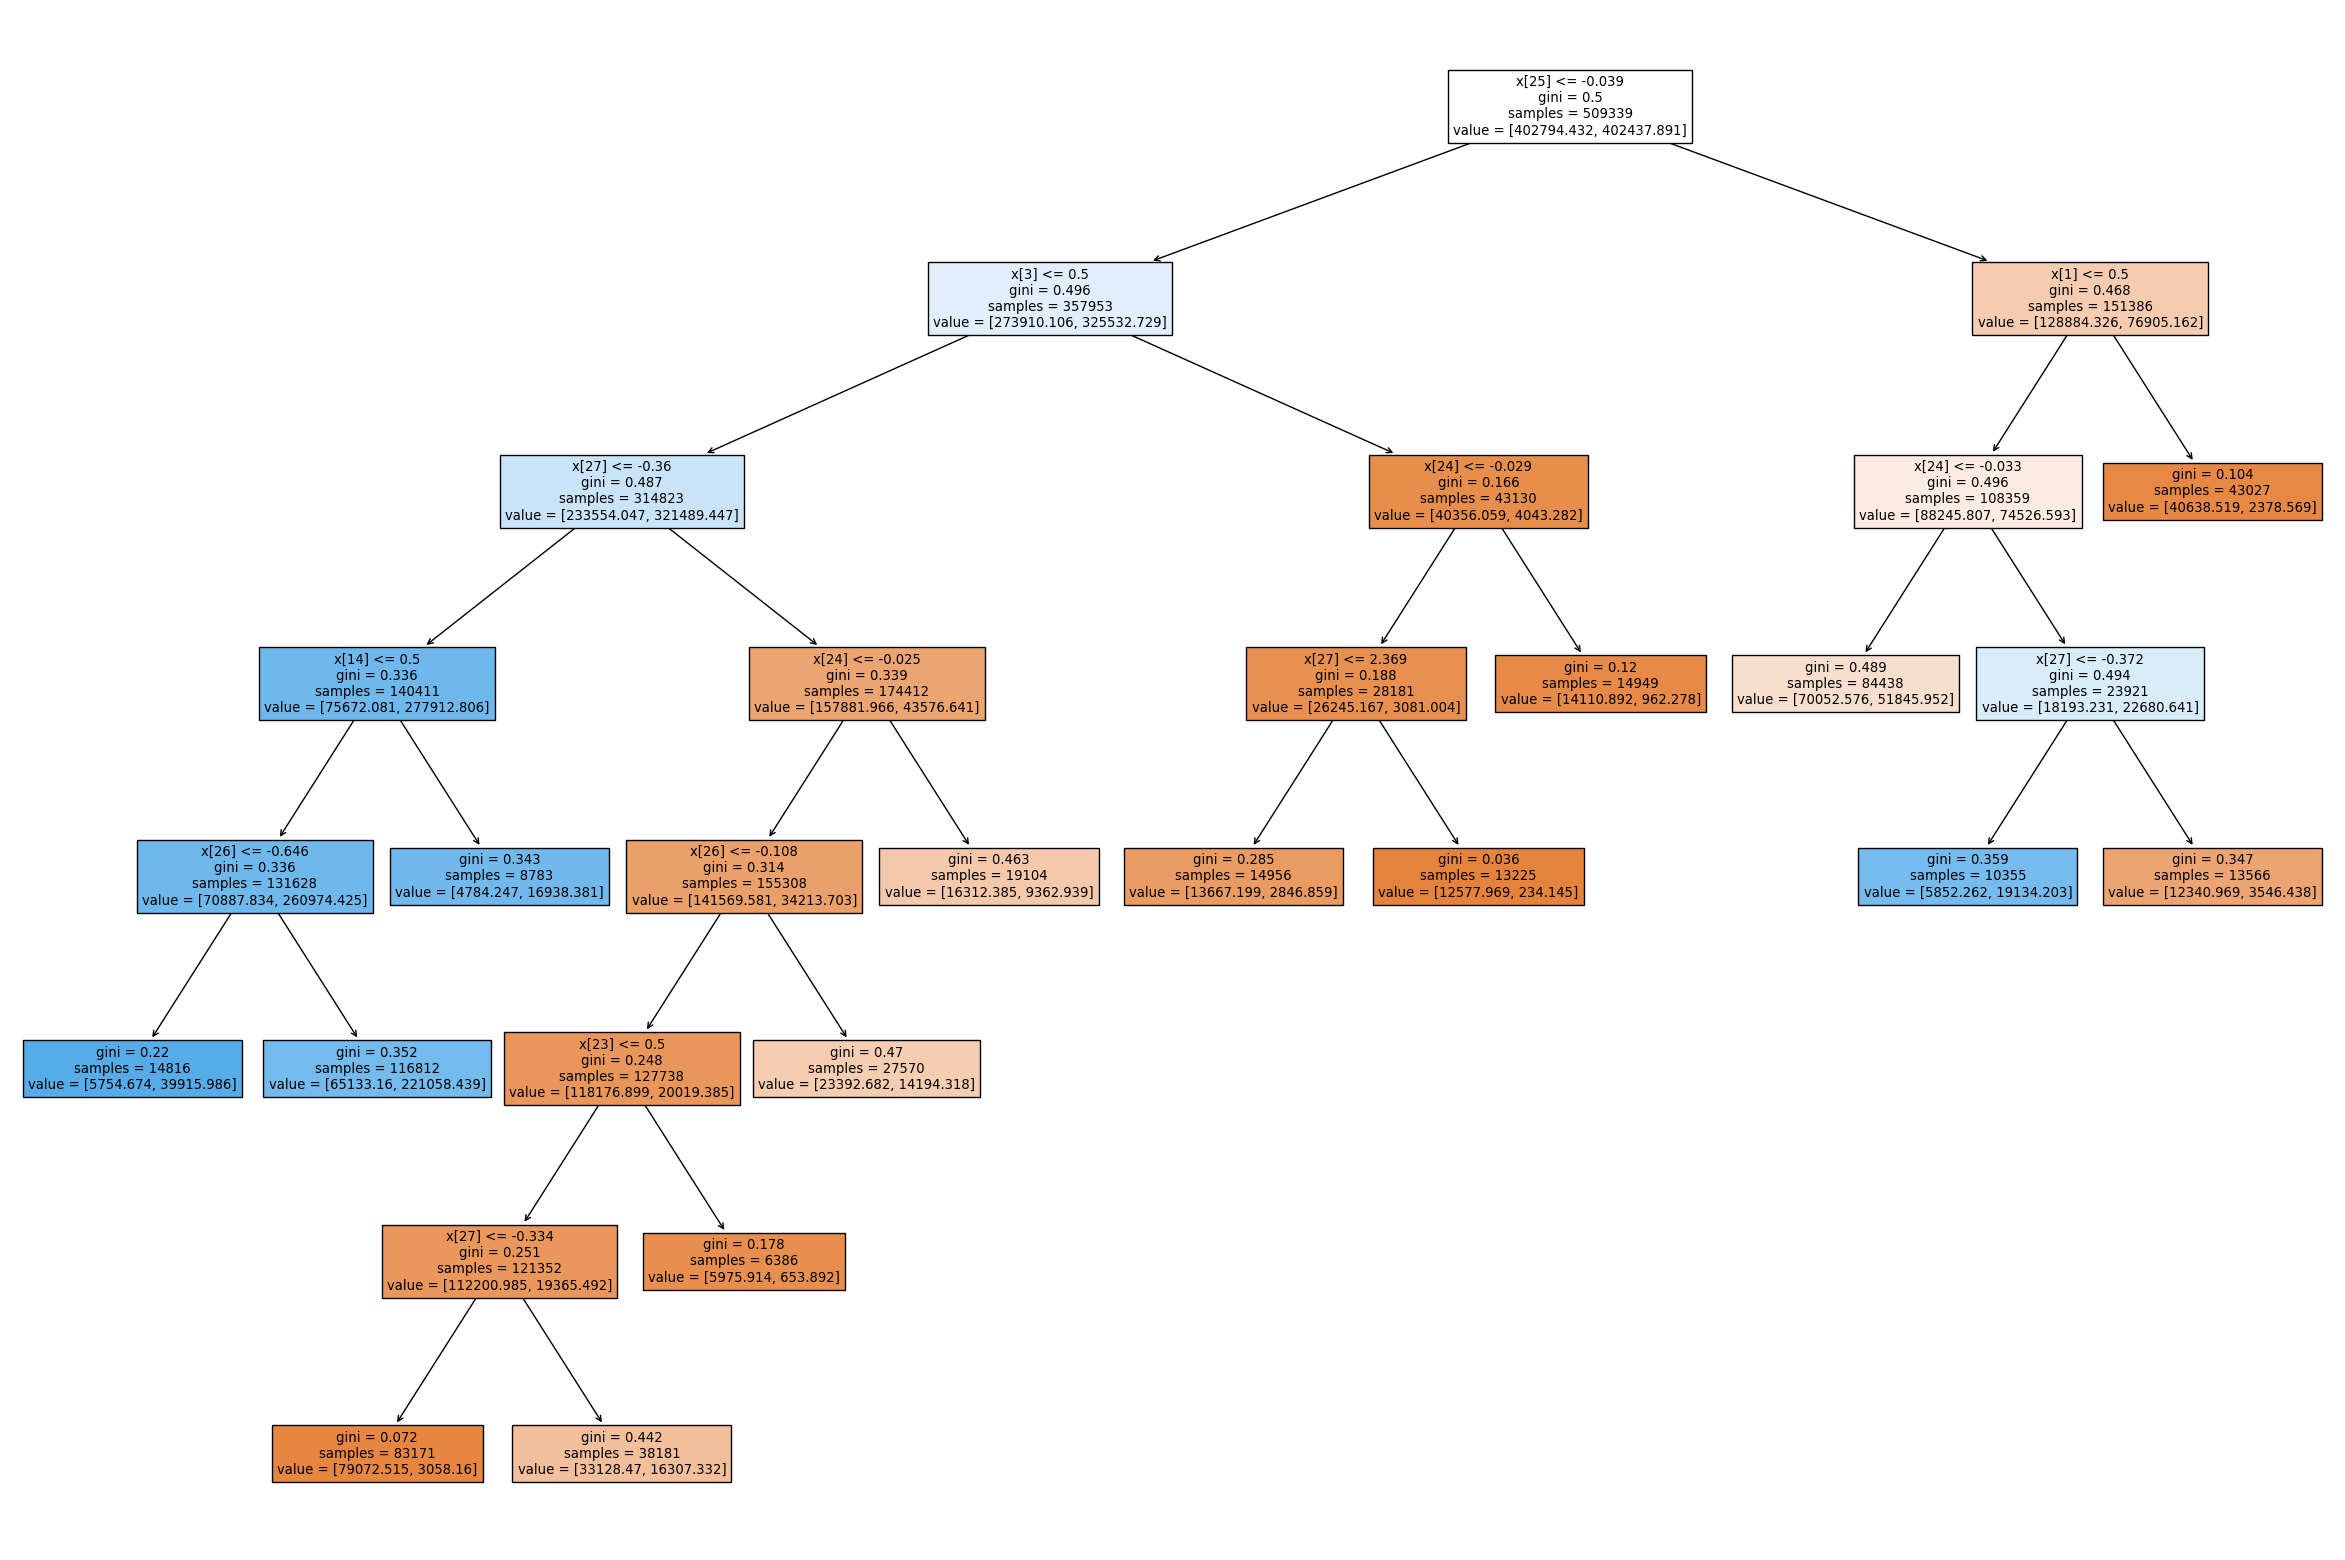

In [ ]:
fig = plt.figure(figsize=(30,20))
plot_tree(forest.named_steps['randomforestclassifier'].estimators_[0],filled=True)
plt.show()

In [12]:
xgb= make_pipeline(
        transformer,
        XGBClassifier(
            max_depth=10,
            learning_rate=0.1,
            n_estimators=100,
            gamma=50, 
            min_child_weight=0,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.005
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
xgb.fit(X_train,y_train)

cross_val=cross_validate(xgb, X_train, y_train,scoring='f1_macro',cv=5)

cross_val['test_score'].mean()

/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:03] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:25] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:42] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:59] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:13:16] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:13:33] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.873737550118529

In [23]:
xgb.predict_proba(X_train)

array([[0.9934096 , 0.00659043],
       [0.9702435 , 0.0297565 ],
       [0.98334605, 0.01665396],
       ...,
       [0.99217486, 0.00782516],
       [0.94289565, 0.05710433],
       [0.84466475, 0.15533523]], dtype=float32)

In [19]:
test= np.array([0,0,4,0,60000.0,'Retail trade',84])
B=dict(zip(X.columns,test))
B


{'UrbanRural': '0',
 'CreateJob': '0',
 'NoEmp': '4',
 'Real_estate': '0',
 'GrAppv': '60000.0',
 'Industry': 'Retail trade',
 'Term': '84'}

In [20]:
A= pd.DataFrame( B, index=[0])
A

,UrbanRural,CreateJob,NoEmp,Real_estate,GrAppv,Industry,Term
0,0,0,4,0,60000.0,Retail trade,84


In [21]:
xgb.predict(A)[0]

0

In [ ]:
f1_score(y_train,y_pred, average='macro')

0.8760262104134251

In [45]:
y_pred = (xgb.predict_proba(X_train)[:,1] >= 0.3).astype(bool)

In [46]:
# y_pred=xgb.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95    664423
           1       0.75      0.85      0.80    141041

    accuracy                           0.92    805464
   macro avg       0.86      0.89      0.88    805464
weighted avg       0.93      0.92      0.93    805464



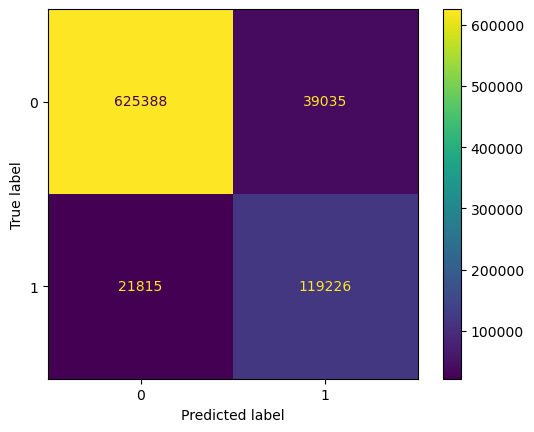

In [47]:
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# fig = plt.figure(figsize=(30,20))
# plot_tree(forest.named_steps['classifier'].estimators_[0],filled=True)
# plt.show()

AttributeError: module 'xgboost' has no attribute 'named_steps'

<Figure size 4000x2000 with 0 Axes>

In [ ]:
# lo_reg = make_pipeline(
#     transformer,
#     LogisticRegression(
#         penalty='l2',
#         solver='saga',
#         class_weight='balanced',
#         multi_class='ovr'
#         )
#     )

# # Entrainement de notre modèle en utilisant les paramètres par défaut 
# lo_reg.fit(X_train,y_train)

# # Score de notre modèle après la cross_validation
# cross_val=cross_validate(lo_reg, X_train, y_train,scoring='f1',cv=5)
# cross_val['test_score'].mean()

### Utilisation d'un RandomSearch pour obtenir une idée de l'ordre de grandeur des paramètres

In [ ]:
#Pour trouver le nom des paramètres590599
forest.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc40e5e340>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc40e5e3a0>)])),
  ('randomforestclassifier',
   RandomForestClassifier(class_weight='balanced', max_depth=10,
                          min_samples_leaf=2500, min_samples_split=2500))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdc40e5e340>),
                                 ('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector o

In [ ]:
# param_rand = {'randomforestclassifier__min_samples_leaf':np.arange(1000,10000,100),
#               'randomforestclassifier__max_depth':np.arange(5,10,1),
#               'randomforestclassifier__min_samples_split':np.arange(1000,10000,100)
#                 }
                
# random_search = RandomizedSearchCV(forest, param_distributions=param_rand,scoring='f1', n_iter=1, cv=5, random_state=42)

# random_search.fit(X_train, y_train)
# print(random_search.best_params_)

{'randomforestclassifier__min_samples_split': 5500, 'randomforestclassifier__min_samples_leaf': 9500, 'randomforestclassifier__max_depth': 6}


In [ ]:
# random_search.best_estimator_
# random_search.best_score_

0.5630030033788367

### Utilisation d'un GridSearch pour cibler les meilleurs paramètres

In [ ]:
# params = {'randomforestclassifier__min_samples_leaf':np.arange(2150,2300,1),
#           'randomforestclassifier__max_depth':[6]
#             }

# grid=GridSearchCV(forest, param_grid=params, scoring='f1', cv=5)
# grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# grid.best_score_

0.37606272607064106

In [11]:
with open('xgb.pkl', 'wb') as file:
  pickle.dump(xgb, file)
